In [1]:
from scipy.stats import scoreatpercentile, ttest_1samp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from os import path

from utils.io import get_args, get_firstlevel_dir, get_secondlevel_dir, save_args

In [2]:
np.random.seed(2022)

In [3]:
args = get_args(['-dataset', '2'])

firstlevel_dir = get_firstlevel_dir(args)

secondlevel_dir = get_secondlevel_dir(args)
save_args(args, secondlevel_dir)

ridx, cidx = np.tril_indices(args.nROI, -1)

contrasts_files = sorted(glob(path.join(firstlevel_dir, '*.csv')))

In [4]:
contrasts_files

['results/1stlevels/dataset-2/desc-standard/model-VTC_convolved_contrast-vtc_datatype-edge.csv',
 'results/1stlevels/dataset-2/desc-standard/model-VTCcorr_contrast-VTCcorr_datatype-edge.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialPrecursor_datatype-edge.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-common_fail_datatype-edge.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-common_fail_datatype-roi.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail+probe_success_datatype-edge.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail+probe_success_datatype-roi.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail_datatype-edge.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail_datatype-roi.csv',
 'results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_success-probe_fail_da

### NBS Helpers

In [5]:
# NBS code is adapted from here: https://github.com/aestrivex/bctpy/blob/master/bct/nbs.py#L14
# because we want to control the permutations so they are the same for the two permutation tests, and because we only have 1 matrix rahter than two

def binarize(W, copy=True):
    '''
    https://github.com/aestrivex/bctpy/blob/32c7fe7345b281c2d4e184f5379c425c36f3bbc7/bct/utils/other.py#L169
    '''
    if copy:
        W = W.copy()
    W[W != 0] = 1
    return W

def get_components(A):
    '''
    https://github.com/aestrivex/bctpy/blob/32c7fe7345b281c2d4e184f5379c425c36f3bbc7/bct/algorithms/clustering.py#L452
    '''
    if not np.all(A == A.T):  # ensure matrix is undirected
        raise Error('get_components can only be computed for undirected'
                            ' matrices.  If your matrix is noisy, correct it with np.around')
    
    A = binarize(A, copy=True)
    n = len(A)
    np.fill_diagonal(A, 1)

    edge_map = [{u,v} for u in range(n) for v in range(n) if A[u,v] == 1]
    union_sets = []
    for item in edge_map:
        temp = []
        for s in union_sets:

            if not s.isdisjoint(item):
                item = s.union(item)
            else:
                temp.append(s)
        temp.append(item)
        union_sets = temp

    comps = np.array([i+1 for v in range(n) for i in 
        range(len(union_sets)) if v in union_sets[i]])
    comp_sizes = np.array([len(s) for s in union_sets])

    return comps, comp_sizes

In [6]:
def get_max_edges(p_vals, NBS_p_thresh, ixes=np.where(np.tril(np.ones((args.nROI, args.nROI)), -1))):
    m = np.size(ixes, axis=1)
    
    ind_t, = np.where(p_vals < NBS_p_thresh)
    
    adj = np.zeros((args.nROI, args.nROI))
    adj[(ixes[0][ind_t], ixes[1][ind_t])] = 1
    adj = adj + adj.T
    a, sz = get_components(adj)  # these are descriptions of the number of nodes, need to be converted to num. edges

    ind_sz, = np.where(sz > 1)
    ind_sz += 1  # a is 1 indexed b/c 0 = not in a component
    nr_components = np.size(ind_sz)
    
    sz_links = np.zeros((nr_components))
    for i in range(nr_components):
        nodes, = np.where(ind_sz[i] == a)
        sz_links[i] = np.sum(adj[np.ix_(nodes, nodes)]) / 2

    if np.size(sz_links):
        return np.max(sz_links)
    else:
        return 0
    
def NBS_threshold(p_vals, NBS_p_thresh, size_thresh, ixes=np.where(np.tril(np.ones((args.nROI, args.nROI)), -1))):
    print('NBS edge threshold: ', size_thresh)
    m = np.size(ixes, axis=1)
    
    ind_t, = np.where(p_vals < NBS_p_thresh)
    print('double checking initial edges: ', len(ind_t))
    
    adj = np.zeros((args.nROI, args.nROI))
    adj[(ixes[0][ind_t], ixes[1][ind_t])] = 1
    adj = adj + adj.T
    a, sz = get_components(adj)  # these are descriptions of the number of nodes, need to be converted to num. edges

    ind_sz, = np.where(sz > 1)
    ind_sz += 1  # a is 1 indexed b/c 0 = not in a component
    nr_components = np.size(ind_sz)
    
    for i in range(nr_components):
        nodes, = np.where(ind_sz[i] == a)
        size = np.sum(adj[np.ix_(nodes, nodes)]) / 2
        print('number of edges in this component: ', size)
        if size > size_thresh:
            adj[np.ix_(nodes, nodes)] *= (i + 2)
    
    adj[np.where(adj)] -= 1  # drop every edge that wasn't in a large component
    
    return adj

# Secondlevels

results/1stlevels/dataset-2/desc-standard/model-VTC_convolved_contrast-vtc_datatype-edge.csv
total number of edges initially:  471
NBS edge threshold:  474.0499999999993
double checking initial edges:  471
number of edges in this component:  1.0
number of edges in this component:  1.0
number of edges in this component:  1.0
number of edges in this component:  1.0
number of edges in this component:  467.0


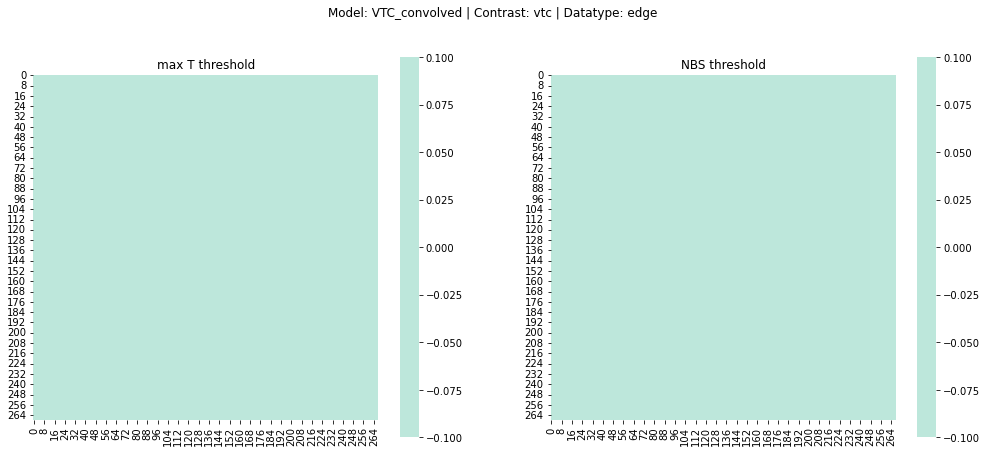

results/1stlevels/dataset-2/desc-standard/model-VTCcorr_contrast-VTCcorr_datatype-edge.csv
total number of edges initially:  828
NBS edge threshold:  487.0
double checking initial edges:  828
number of edges in this component:  1.0
number of edges in this component:  827.0


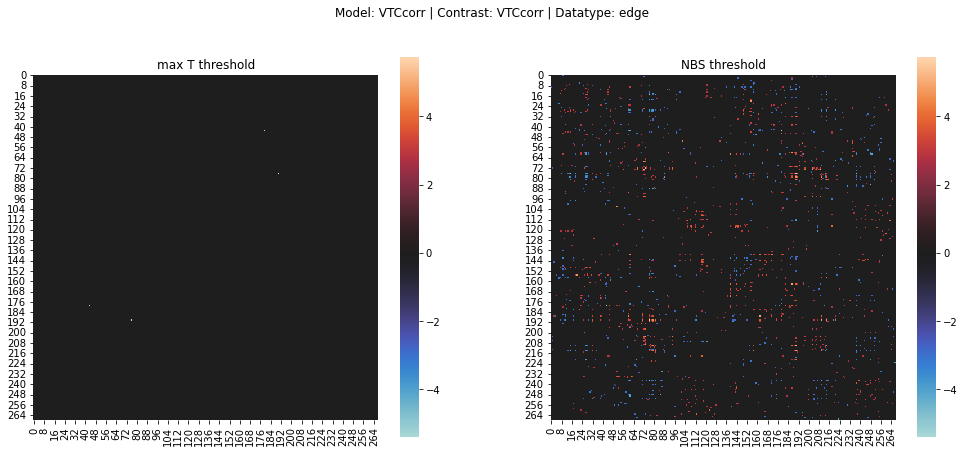

results/1stlevels/dataset-2/desc-standard/model-trialPrecursor_datatype-edge.csv
total number of edges initially:  622
NBS edge threshold:  468.0
double checking initial edges:  622
number of edges in this component:  1.0
number of edges in this component:  621.0


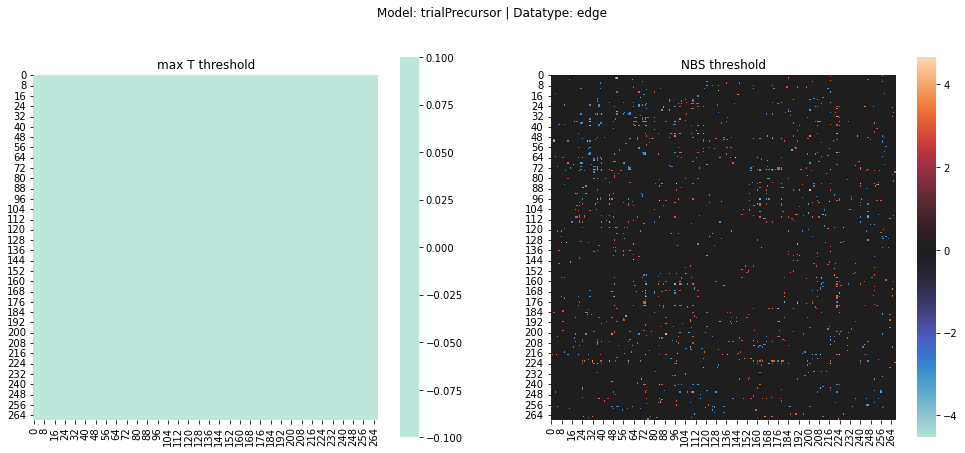

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-common_fail_datatype-edge.csv
total number of edges initially:  995
NBS edge threshold:  507.0
double checking initial edges:  995
number of edges in this component:  995.0


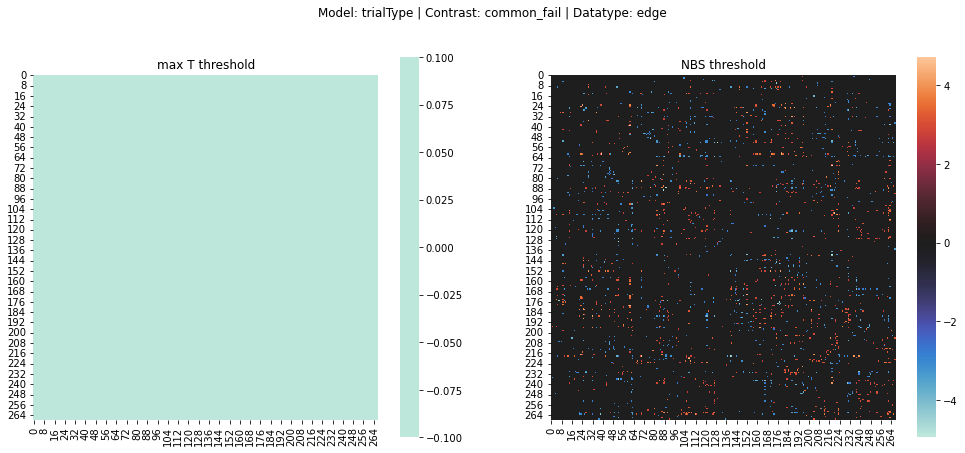

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-common_fail_datatype-roi.csv
total number of edges initially:  5381
NBS edge threshold:  604.0
double checking initial edges:  5381
number of edges in this component:  5381.0


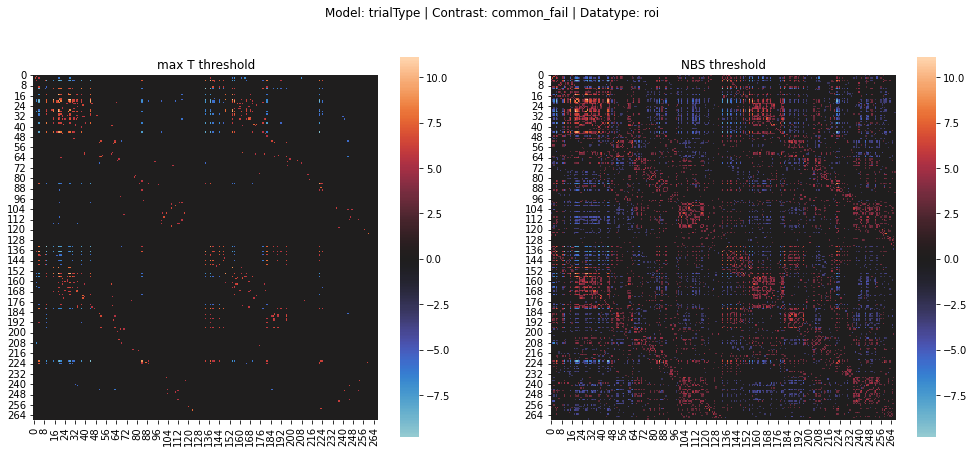

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail+probe_success_datatype-edge.csv
total number of edges initially:  5315
NBS edge threshold:  554.0
double checking initial edges:  5315
number of edges in this component:  5315.0


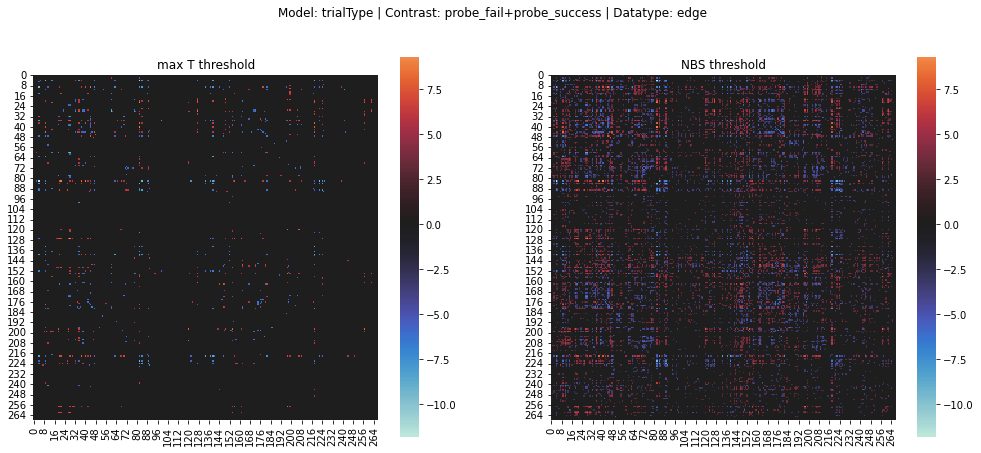

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail+probe_success_datatype-roi.csv
total number of edges initially:  13491
NBS edge threshold:  810.0499999999993
double checking initial edges:  13491
number of edges in this component:  13491.0


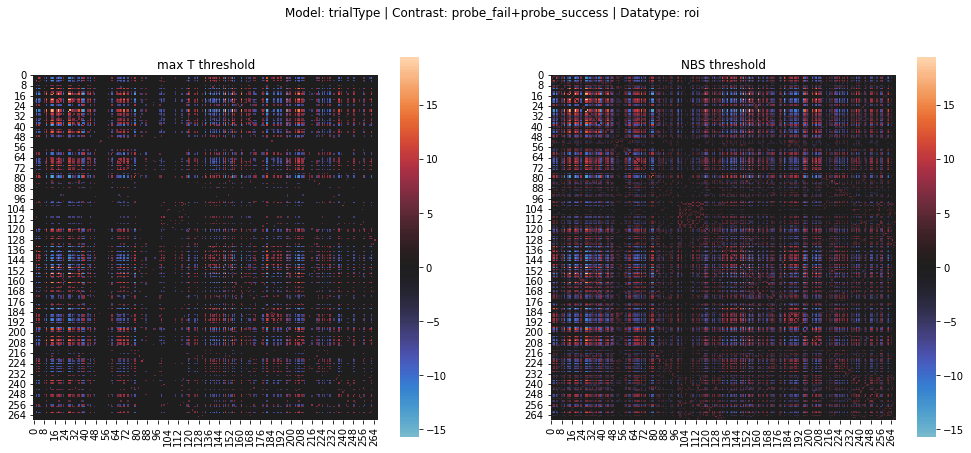

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail_datatype-edge.csv
total number of edges initially:  2911
NBS edge threshold:  499.0
double checking initial edges:  2911
number of edges in this component:  2911.0


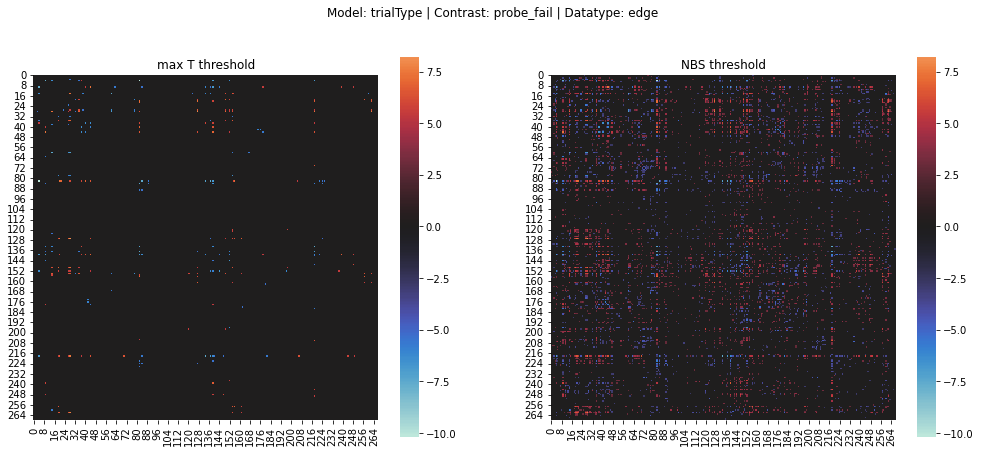

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_fail_datatype-roi.csv
total number of edges initially:  9427
NBS edge threshold:  691.0
double checking initial edges:  9427
number of edges in this component:  9427.0


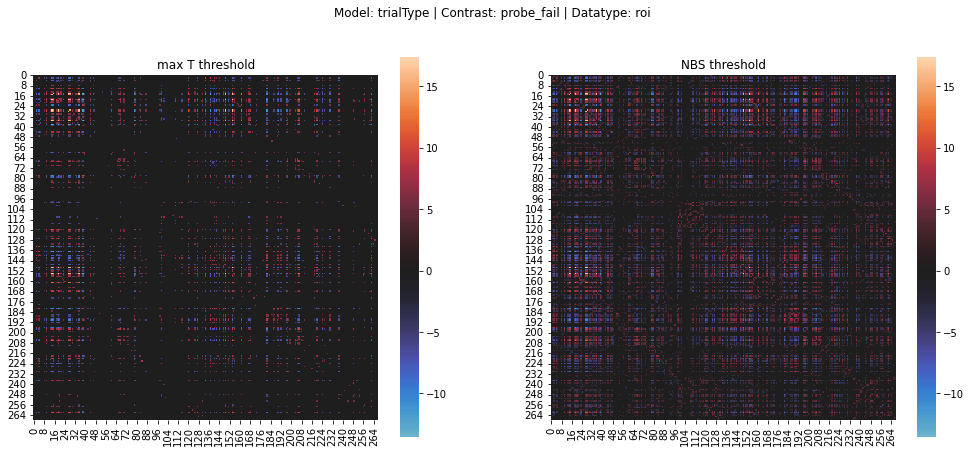

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_success-probe_fail_datatype-edge.csv
total number of edges initially:  1459
NBS edge threshold:  484.0
double checking initial edges:  1459
number of edges in this component:  1459.0


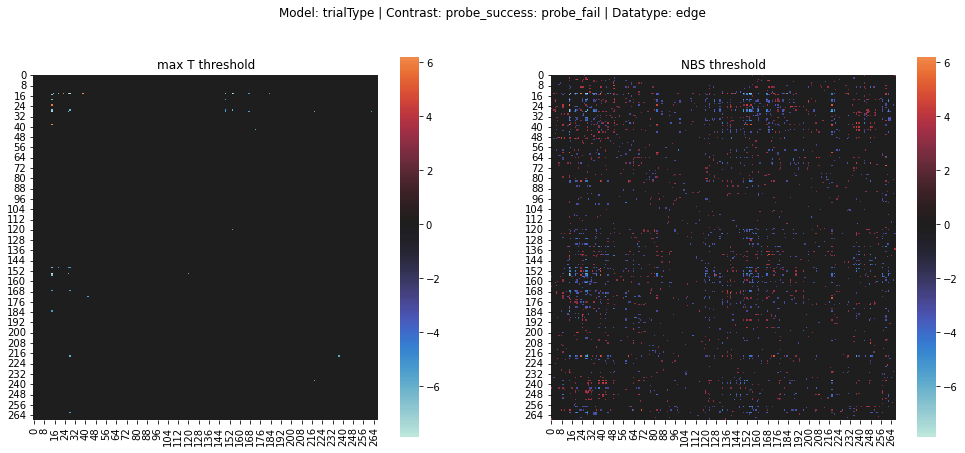

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_success-probe_fail_datatype-roi.csv
total number of edges initially:  4012
NBS edge threshold:  535.0499999999993
double checking initial edges:  4012
number of edges in this component:  4012.0


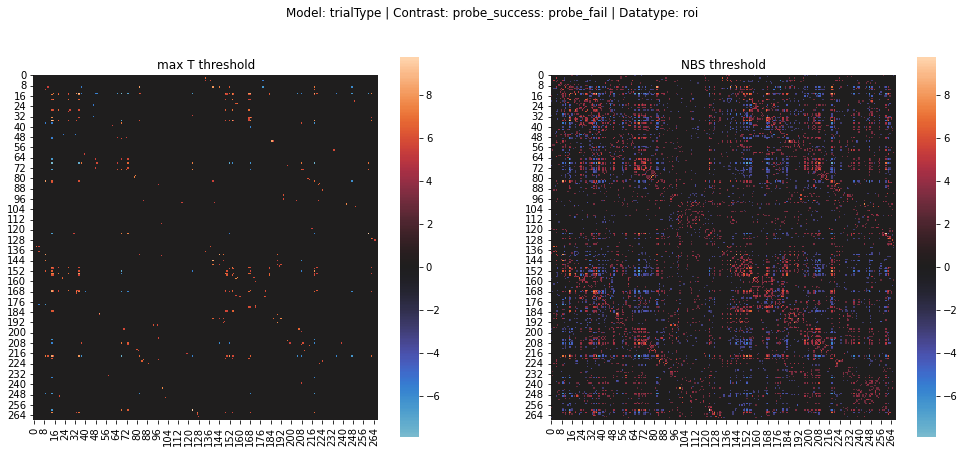

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_success_datatype-edge.csv
total number of edges initially:  5404
NBS edge threshold:  561.0
double checking initial edges:  5404
number of edges in this component:  5404.0


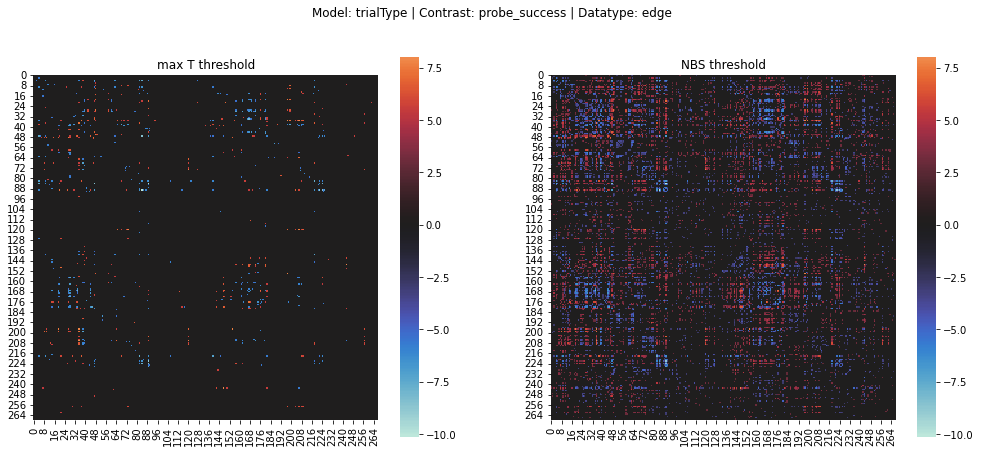

results/1stlevels/dataset-2/desc-standard/model-trialType_contrast-probe_success_datatype-roi.csv
total number of edges initially:  13914
NBS edge threshold:  849.0
double checking initial edges:  13914
number of edges in this component:  13914.0


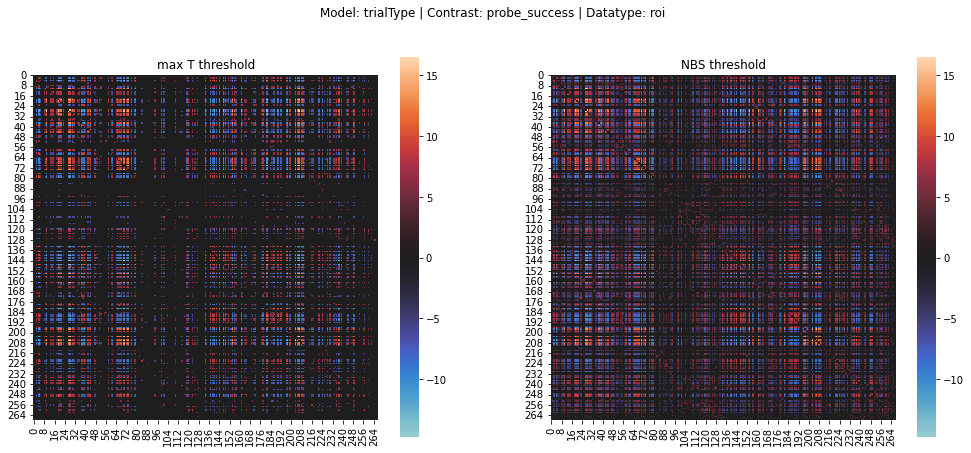

In [7]:
nan_policy = 'propagate' if args.drop_nan_nodes else 'omit'

for contrast_file in contrasts_files:
    
    #check to see if files exist, skip if not overwriting
    file_info = contrast_file.split('/')[-1].replace('.csv', '')
    maxT_file = path.join(secondlevel_dir, file_info+'_2ndlevel-maxT.csv')
    nbs_file = path.join(secondlevel_dir, file_info+'_2ndlevel-NBS.csv')
    if path.exists(maxT_file) and path.exists(nbs_file) and not args.overwrite:
        pass
    else:
        print(contrast_file)
        con_data = pd.read_csv(contrast_file).values
        if int(args.dataset)==1 and (not args.include_s7):
            con_data = np.delete(con_data, 6, axis=0)

        # observed results
        obs_res = ttest_1samp(con_data, popmean=0, axis=0, nan_policy='omit')
        obs_Fs = obs_res.statistic**2
        obs_ps = obs_res.pvalue

        # Permutation Distributions
        max_T_dist = np.full((args.n_perms, ), np.nan)
        max_comp_dist = np.full((args.n_perms, ), np.nan)
        random_intercepts = np.random.choice([1, -1], size=(con_data.shape[0], args.n_perms))  # make all the sign flips at once
        for perm_idx in range(args.n_perms):

            perm_data = con_data * random_intercepts[:, perm_idx, np.newaxis]
            perm_res = ttest_1samp(perm_data, popmean=0, axis=0, nan_policy=nan_policy)

            # max T
            max_T_dist[perm_idx] = np.nanmax(perm_res.statistic**2)

            # NBS
            max_comp_dist[perm_idx] = get_max_edges(perm_res.pvalue, args.NBS_p_thresh)


        # max T Thresholding 
        max_T_thresh = scoreatpercentile(max_T_dist, 100*(1-args.perm_p_thresh))
        max_T_thresholded_res = np.where(obs_Fs > max_T_thresh, obs_res.statistic.data, 0.0)
        max_T_ADJ = np.full((args.nROI, args.nROI), 0.0)
        max_T_ADJ[ridx, cidx] = max_T_thresholded_res
        max_T_ADJ = max_T_ADJ + max_T_ADJ.T

        # NBS Thresholding
        print('total number of edges initially: ', np.sum(np.where(obs_ps < args.NBS_p_thresh, 1, 0)))
        NBS_BINARY_ADJ = binarize(
            NBS_threshold(
                obs_ps,
                args.NBS_p_thresh,
                scoreatpercentile(max_comp_dist, 100*(1-args.perm_p_thresh))
            )
        )

        UNTHRESH_ADJ = np.full((args.nROI, args.nROI), 0.0)
        UNTHRESH_ADJ[ridx, cidx] = obs_res.statistic.data
        UNTHRESH_ADJ = UNTHRESH_ADJ + UNTHRESH_ADJ.T

        NBS_ADJ = UNTHRESH_ADJ * NBS_BINARY_ADJ

        # SAVE & PLOT
        file_info = contrast_file.split('/')[-1].replace('.csv', '')
        pd.DataFrame(max_T_ADJ).to_csv(maxT_file, index=False, header=False)
        pd.DataFrame(NBS_ADJ).to_csv(nbs_file, index=False, header=False)

        fig, axes = plt.subplots(1, 2, figsize=(17, 7))
        sns.heatmap(max_T_ADJ, square=True, ax=axes[0], center=0)
        axes[0].title.set_text('max T threshold')
        _ = sns.heatmap(NBS_ADJ, square=True, ax=axes[1], center=0)
        axes[1].title.set_text('NBS threshold')
        _ = plt.suptitle(file_info.replace('model', 'Model').replace('_contrast', ' | Contrast').replace('_datatype', ' | Datatype').replace('-', ': '))
        plt.show()
        plt.close()